### Isolation Forest for Time-Series Anomaly Detection 

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import moment, skew, kurtosis
from statsmodels.tsa.stattools import acf
from scipy.stats import entropy
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix

#### Data preprocessing

In [137]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836
...,...,...
22690,2014-02-19 15:05:00,98.185415
22691,2014-02-19 15:10:00,97.804168
22692,2014-02-19 15:15:00,97.135468
22693,2014-02-19 15:20:00,98.056852


Anomalies labeled according to the NAB github (https://github.com/numenta/NAB/blob/master/labels/):

In [138]:
data['anomaly'] = 0 # 1 = anomaly, 0 = normal
instances_of_anomaly = [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
                        ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
                        ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
                        ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]

# Marking the instances of anomaly in the dataset
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'anomaly'] = 1

Plot the data with anomalies marked

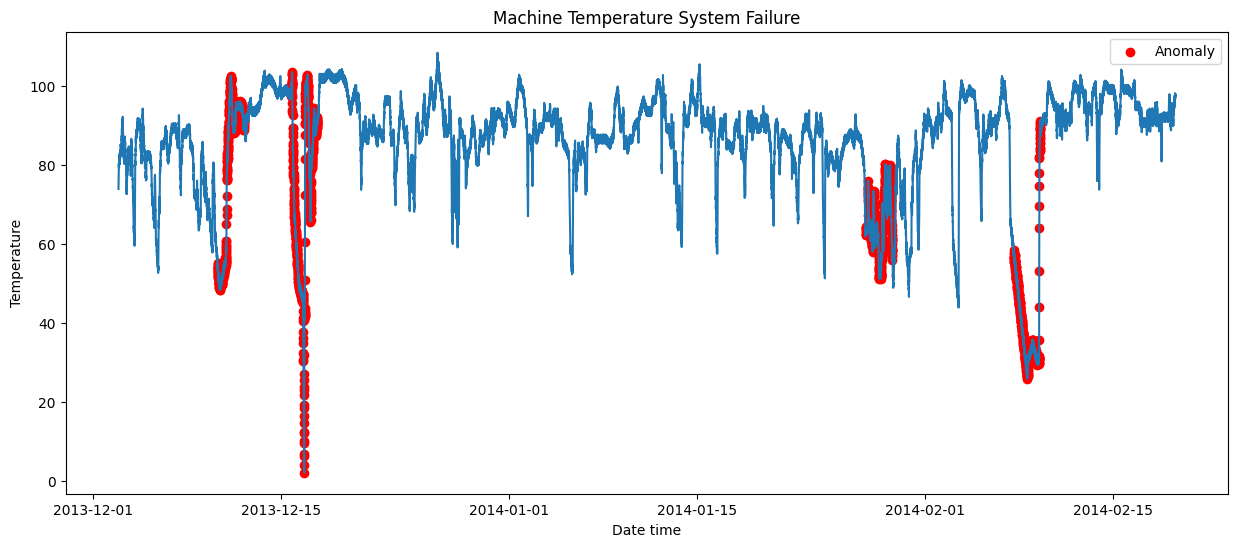

In [139]:
plt.figure(figsize=(15, 6))
plt.plot(data['timestamp'], data['value'])
plt.scatter(data['timestamp'][data['anomaly'] == 1], data['value'][data['anomaly'] == 1], color='red', label='Anomaly')
plt.title('Machine Temperature System Failure')
plt.xlabel('Date time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

#### Split data into training, validation and testing sets
60% training, 20% validation and 20% testing

In [140]:
data_train = data[0:int(len(data)*0.6)]
data_val = data[int(len(data)*0.6):int(len(data)*0.8)]
data_test = data[int(len(data)*0.8):]

labels_train = data_train['anomaly']
labels_val = data_val['anomaly']
labels_test = data_test['anomaly']

X_train = data_train.drop(['anomaly'], axis=1)
X_val = data_val.drop(['anomaly'], axis=1)
X_test = data_test.drop(['anomaly'], axis=1)

contamination_coef = sum(labels_train) / len(labels_train)

Normalize the data according to the training set

In [141]:
mean = X_train['value'].mean()
std = X_train['value'].std()
X_train['value'] = (X_train['value'] - mean) / std
X_val['value'] = (X_val['value'] - mean) / std
X_test['value'] = (X_test['value'] - mean) / std

#### Model

Extract features from time series data

In [142]:
def extract_features(time_series, window_size):
    features = []
    for i in range(len(time_series) - window_size + 1):
        window = time_series[i:i+window_size]
        mean = np.mean(window)
        std_dev = np.std(window)
        skewness = moment(window, moment=3)
        kurtosis_val = moment(window, moment=4)
        # autocorr_lag1 = acf(window, fft=False)[1]  # Autocorrelation at lag 1
        fourier_coeffs = np.abs(fft(window))[:window_size//2]  # Fourier transform coefficients (amplitudes)
        
        feature_vector = [mean, std_dev, skewness, kurtosis_val]
        feature_vector.extend(fourier_coeffs)
        
        features.append(feature_vector)
    
    return np.array(features)

In [143]:
window_size = 100
X_train_features = extract_features(np.array(X_train['value']), window_size)
X_val_features = extract_features(np.array(X_val['value']), window_size)
X_test_features = extract_features(np.array(X_test['value']), window_size)

Train Isolation Forest model

Contamination parameter sets the proportion of anomalies expected in the data

In [144]:
model = IsolationForest(contamination=contamination_coef)
model.fit(X_train_features)

IsolationForest(contamination=0.08327825512227363)

In [145]:
# Predict anomaly scores
anomaly_scores = model.decision_function(X_val_features)

In [146]:
# Threshold for classifying instances as anomalies (adjust as needed)
threshold = np.percentile(anomaly_scores, 0.5)

In [147]:
# Classify instances as normal (0) or anomalous (1)
predictions = np.where(anomaly_scores >= threshold, 0, 1)

In [177]:
def assign_point_predictions(predictions, window_size):
    point_predictions = np.zeros(len(predictions)+window_size-1)
    for i, point in enumerate(point_predictions):
        if i < window_size//2:
            point_predictions[i] = predictions[0]
        elif i > len(predictions) - window_size :
            point_predictions[i] = predictions[-1]
        else:
            point_predictions[i] = predictions[i*window_size//2]
    
    return point_predictions

In [178]:
assign_point_predictions([1,0,0,0,1], 3)

array([1., 0., 0., 1., 1., 1., 1.])

In [181]:
point_predictions = assign_point_predictions(predictions, window_size)

IndexError: index 4450 is out of bounds for axis 0 with size 4440

In [151]:
# Output predictions
print("Predictions:", predictions)

# Evaluate model performance
accuracy = accuracy_score(labels_val, point_predictions)
conf_matrix = confusion_matrix(labels_val, point_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Predictions: [0 0 0 ... 0 0 0]


ValueError: Found input variables with inconsistent numbers of samples: [4539, 4440]

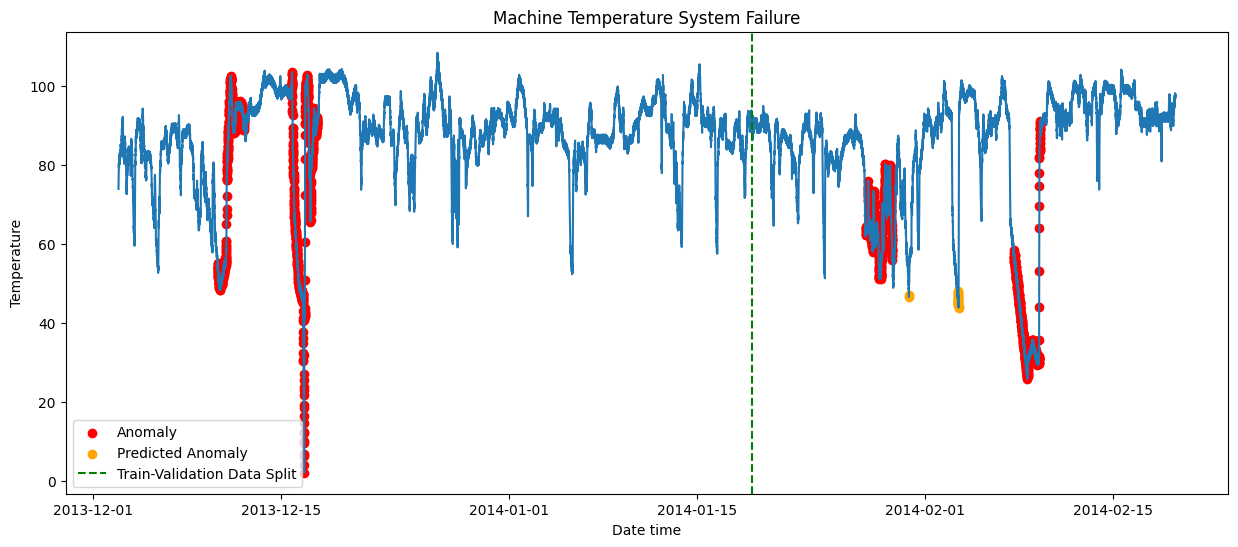

In [ ]:
# Plot the time series data with the predicted anomalies and the actual anomalies ...
# ...as well as showcasing where training, validation and test data is split
plt.figure(figsize=(15, 6))
plt.plot(data['timestamp'], data['value'])
plt.scatter(data['timestamp'][data['anomaly'] == 1], data['value'][data['anomaly'] == 1], color='red', label='Anomaly')
plt.scatter(data_val['timestamp'][predictions == 1], data_val['value'][predictions == 1], color='orange', label='Predicted Anomaly')
plt.title('Machine Temperature System Failure')
plt.xlabel('Date time')
plt.ylabel('Temperature')
plt.axvline(data_val['timestamp'].iloc[0], color='green', linestyle='--', label='Train-Validation Data Split')
# plt.axvline(data_test['timestamp'].iloc[0], color='blue', linestyle='--', label='Validation-Test Data Split')
plt.legend()
plt.show()
